# Flight Price Prediction

# Import Libraries

In [1]:
try:
    import warnings
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import datetime as dt
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import LabelEncoder
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
    warnings.filterwarnings('ignore')
    %matplotlib inline

except ModuleNotFoundError as e:
    print(e)
    
    
flight_data = pd.read_excel('Data_Train.xlsx')
flight_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Analyze your Data

In [2]:
class EDA:
    
    def dimensions(self,dataset):
        print('total rows : ',dataset.shape[0] , 'and' , 'total numbers of features are : ', dataset.shape[1])
        
  
    def null_values(self,dataset):
        return dataset.isnull().sum()
    
    def total_source(self,dataset):
        source = {}
        for i in dataset['Source']:
            if i not in source:
                source[i] = 1
            else:
                source[i] = source[i] + 1
        return source
    
    def total_stops(self,dataset):
        stops = {}
        for i in dataset['Total_Stops']:
            if i not in stops:
                stops[i] = 1
            else:
                stops[i] = stops[i] + 1
        return stops
    
    def total_destinations(self,dataset):
        destinations = {}
        for i in dataset['Destination']:
            if i not in destinations:
                destinations[i] = 1
            else:
                destinations[i] = destinations[i] + 1
        return destinations
    
    def total_airlines(self,dataset):
        flights = {}
        for i in dataset['Airline']:
            if i not in flights:
                flights[i] = 1
            else:
                flights[i] = flights[i] + 1
                
        return flights

e = EDA()
e.dimensions(flight_data)
print()

null = e.null_values(flight_data)
print(null)
print()

source = e.total_source(flight_data)
print('total source are')
print(source)
print()

haults = e.total_stops(flight_data)
print('total stops are')
print(haults)
print()

dest = e.total_destinations(flight_data)
print('total destinations are')
print(dest)
print()

total_flights = e.total_airlines(flight_data)
print('total airlines are')
print(total_flights)

total rows :  10683 and total numbers of features are :  11

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

total source are
{'Banglore': 2197, 'Kolkata': 2871, 'Delhi': 4537, 'Chennai': 381, 'Mumbai': 697}

total stops are
{'non-stop': 3491, '2 stops': 1520, '1 stop': 5625, '3 stops': 45, nan: 1, '4 stops': 1}

total destinations are
{'New Delhi': 932, 'Banglore': 2871, 'Cochin': 4537, 'Kolkata': 381, 'Delhi': 1265, 'Hyderabad': 697}

total airlines are
{'IndiGo': 2053, 'Air India': 1752, 'Jet Airways': 3849, 'SpiceJet': 818, 'Multiple carriers': 1196, 'GoAir': 194, 'Vistara': 479, 'Air Asia': 319, 'Vistara Premium economy': 3, 'Jet Airways Business': 6, 'Multiple carriers Premium economy': 13, 'Trujet': 1}


#                                   Handle The Features

                      our dataset consist of all categorical independent features
                      we need to convert them to numerical to build our model.most
                      of our data is in the datetime form we will extract date day
                      and month 

In [4]:
class Handle_Data:
    
    def null_values(self,dataset):
        for cols in dataset.columns:
            if dataset[cols].isnull().sum() > 0:
                dataset = dataset.dropna(inplace = True)
        return dataset
    
    def create_dummies(self,dataset):
        return pd.get_dummies(dataset[['Source' , 'Total_Stops' , 'Destination']] , drop_first = True)
    
    def concat_data(self,dataset,new):
        return pd.concat([dataset,new],axis = 1)

class Time_Data(Handle_Data):
    
    def arrival_hour(self,dataset):
        return pd.to_datetime(dataset['Arrival_Time']).dt.hour
    
    def arrival_minute(self,dataset):
        return pd.to_datetime(dataset['Arrival_Time']).dt.minute
    
    def dept_hour(self,dataset):
         return pd.to_datetime(dataset['Dep_Time']).dt.hour
        
    def dept_minute(self,dataset):
        return pd.to_datetime(dataset['Dep_Time']).dt.minute
    
    def journey_day(self,dataset):
        return pd.to_datetime(dataset['Date_of_Journey']).dt.day
    
    def journey_month(self,dataset):
         return pd.to_datetime(dataset['Date_of_Journey']).dt.month
        
    def airline_dummies(self,dataset):
        return pd.get_dummies(dataset['Airline'],drop_first=True)
    
    def concat_airlines(self,dataset):
        return pd.concat([dataset , airline_dummies],axis = 1)
    
    
    def duration_data(self,dataset):
        duration = list(dataset['Duration'])
        hours_data = []
        minute_data = []
        for i in range(len(duration)):
            if len(duration[i].split()) != 2:
                if 'h' in duration[i]:
                    duration[i] = duration[i] + " 0m"
                else:
                    duration[i] = "0h " + duration[i]
    
        for i in range(len(duration)):
            hours_data.append(int(duration[i].split(sep = 'h')[0]))
            minute_data.append(int(duration[i].split(sep = 'm')[0].split()[-1]))
        
        dataset['duration hours'] = hours_data
        dataset['duration_minute'] = minute_data
        
    
    def remove_unwanted(self,dataset):
        dataset = dataset.drop(['Airline','Date_of_Journey','Source','Destination','Route','Dep_Time',
                                    'Arrival_Time','Duration','Total_Stops','Additional_Info'],axis = 1)
        return dataset
t = Time_Data()
flight_data = t.null_values(flight_data)
dummies = t.create_dummies(flight_data)
new_data = t.concat_data(flight_data,dummies)
new_data['Arrival Hour'] = t.arrival_hour(new_data)
new_data['Arrival minute'] = t.arrival_minute(new_data)
new_data['departure hour'] = t.dept_hour(new_data)
new_data['departure minute'] = t.dept_minute(new_data)
new_data['day of journey'] = t.journey_day(new_data)
new_data['month of journey'] = t.journey_month(new_data)
airline_dummies = t.airline_dummies(new_data)
new_flight_data = t.concat_airlines(new_data)
t.duration_data(new_flight_data)
new_flight_data = t.remove_unwanted(new_flight_data)

# Seperating Dependent and Independent Features

In [5]:
x = new_flight_data.drop('Price',axis = 1)
y = new_flight_data['Price']

# Feature Selection

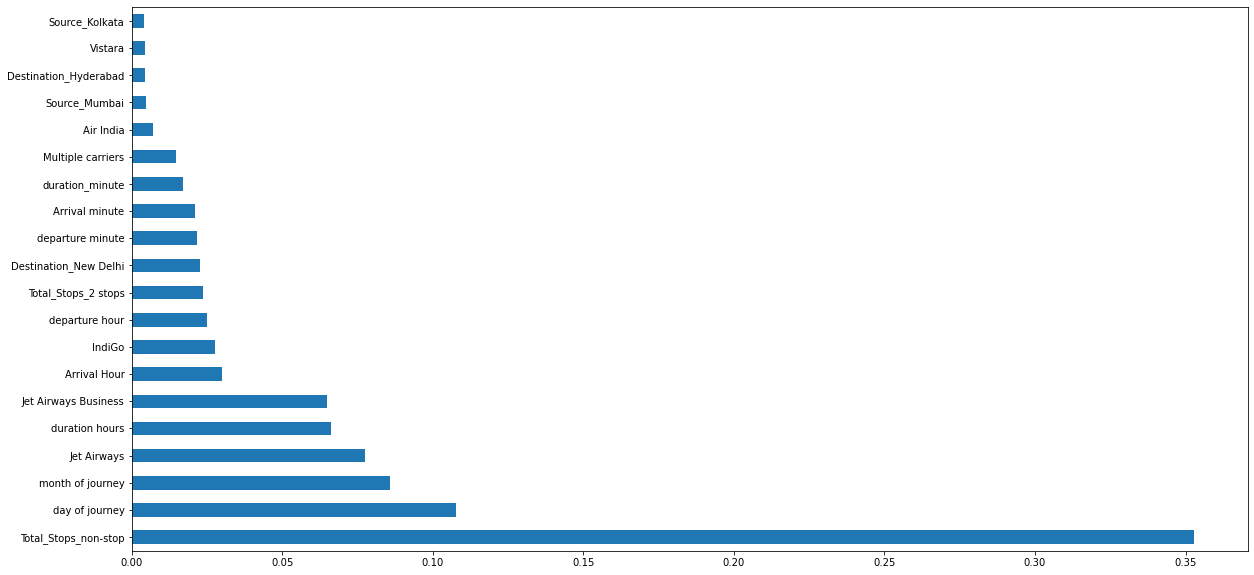

In [6]:
selection_model = ExtraTreesRegressor()
class Feature_Selection:
    
    def select_feature(self,model,x,y):
        model.fit(x,y)
        self.score = model.feature_importances_
    
    def display(self):
        plt.figure(figsize=(20,10))
        scores = pd.Series(self.score , x.columns)
        scores.nlargest(20).plot(kind = 'barh')
f = Feature_Selection()
f.select_feature(selection_model,x,y)
f.display()


# Split the data from train and test

In [7]:
train_x , test_x , train_y , test_y = train_test_split(x,y , test_size = 0.3 , random_state = 42)

# Model Prediction and Measuring the Accuracy

score of our model 0.9550576910004649
test score of our model 0.8017458648990403



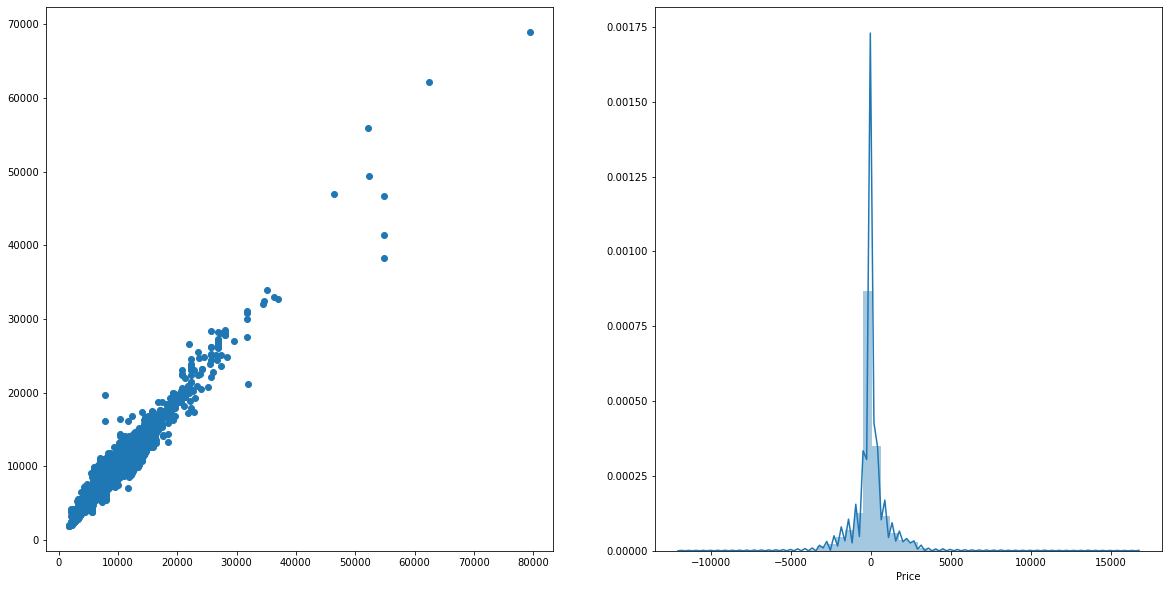

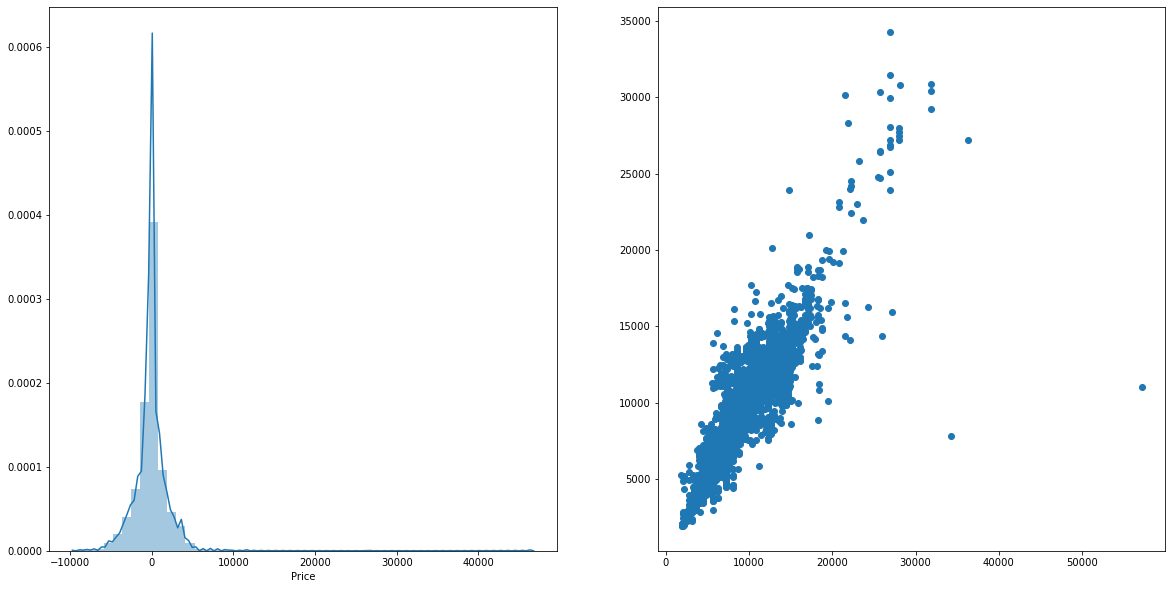

In [9]:
model = RandomForestRegressor()
class Model_Prediction:
    
    def fit_on_train(self,model):
        model.fit(train_x,train_y)
        self.predict_on_train = model.predict(train_x)
        total_train_error = mean_squared_error(train_y,self.predict_on_train)
        total_train_score = r2_score(train_y,self.predict_on_train)
        absolute_error = mean_absolute_error(train_y,self.predict_on_train)
        return total_train_error , total_train_score , absolute_error
        
    def fit_on_test(self,model):
        model.fit(train_x,train_y)
        self.prediction_on_test = model.predict(test_x)
        test_error = mean_squared_error(test_y,self.prediction_on_test)
        total_test_score = r2_score(test_y,self.prediction_on_test)
        return total_test_score
    
    def display_train_result(self):
        plt.figure(figsize=(20,10))
        self.fit_on_train(model)
        plt.subplot(1,2,1)
        plt.scatter(train_y,self.predict_on_train)
        
        plt.subplot(1,2,2)
        sns.distplot(train_y-self.predict_on_train)
        plt.show()
        
        
    def display_test_result(self):
        plt.figure(figsize=(20,10))
        self.fit_on_test(model)
        plt.subplot(1,2,1)
        sns.distplot(test_y-self.prediction_on_test)
        
        plt.subplot(1,2,2)
        plt.scatter(test_y,self.prediction_on_test)
        plt.show()
    
m = Model_Prediction()
training_error , training_score , abs_error = m.fit_on_train(model)
print('score of our model',training_score)

testing_score = m.fit_on_test(model)
print('test score of our model',testing_score)
print()

m.display_train_result()
m.display_test_result()